In [ ]:
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torch.utils.data import DataLoader, Dataset

import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split
from albumentations.pytorch import ToTensorV2
import pickle as pk


In [ ]:
import zipfile
with zipfile.ZipFile('textboxes_annotations.zip', 'r') as zip_ref:
    zip_ref.extractall('textboxes_annotations')

## Data Preprocessing

In [ ]:
data_path = 'panels_annotations/panels_annotations'

image_dir = os.path.join(data_path, 'Images')
annotation_dir = os.path.join(data_path, 'Annotations')

In [ ]:
# Coalesce all annotations of an image into a single dataframe
boxes = []

for annotation_file in tqdm(os.listdir(annotation_dir)):
    image_path = os.path.join(image_dir,annotation_file.replace('.txt','.jpg'))
    annotation_path = os.path.join(annotation_dir,annotation_file)

    image = np.array(Image.open(image_path))
    height, width = image.shape[:2]

    with open(annotation_path) as file:
        for line in file:
            id, xmin, ymin, xmax, ymax = map(int, line.rstrip().split())
            if id == 1:
                id = 0
            boxes.append([image_path, xmin, xmax, ymin, ymax, id])

df = pd.DataFrame(boxes, columns=['image', 'xmin', 'xmax', 'ymin', 'ymax', 'id'])
df.head()

100%|██████████| 443/443 [00:21<00:00, 20.86it/s]


,image,xmin,xmax,ymin,ymax,id
0,panels_annotations/panels_annotations/Images/1...,38,627,34,613,0
1,panels_annotations/panels_annotations/Images/1...,644,1245,34,615,0
2,panels_annotations/panels_annotations/Images/1...,30,635,626,1209,0
3,panels_annotations/panels_annotations/Images/1...,644,1249,626,1213,0
4,panels_annotations/panels_annotations/Images/1...,30,675,1222,1801,0


In [ ]:
# Save the dataframe for future use 
pk.dump(df, open('/drive/MyDrive/CV Data/FasterRCNN/panels_dataframe.pk', 'wb'))

In [ ]:
df = pk.load(open('/drive/MyDrive/CV Data/FasterRCNN/panels_dataframe.pk', 'rb'))
df.head()

,image,xmin,xmax,ymin,ymax,id
0,panels_annotations/panels_annotations/Images/1...,34,643,40,577,0
1,panels_annotations/panels_annotations/Images/1...,640,1187,32,567,0
2,panels_annotations/panels_annotations/Images/1...,40,623,562,1589,0
3,panels_annotations/panels_annotations/Images/1...,642,1183,560,1071,0
4,panels_annotations/panels_annotations/Images/1...,630,1179,1078,1593,0


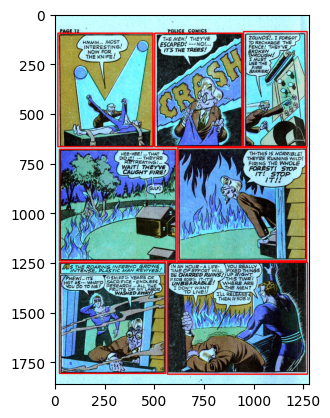

In [ ]:
# Plot a sample image with bounding boxes
sample = df.sample(1)
image_path = sample['image'].values[0]
image = cv2.imread(image_path)

for row in df[df['image'] == image_path].itertuples():
    cv2.rectangle(image, (row.xmin, row.ymin), (row.xmax, row.ymax), (255, 0, 0), 5)
    plt.imshow(image)

In [ ]:
# Split the dataset into train and test
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

In [ ]:
# Define the training tranforms
import albumentations as A

def get_train_transform():
    return A.Compose([
        A.MotionBlur(p=0.2),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.Blur(blur_limit=3, p=0.1),
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc',
        'label_fields': ['labels']
    })

# Define the validation transforms
def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc', 
        'label_fields': ['labels']
    })

In [ ]:
# Create the dataset class

class PanelDataset(Dataset):
    def __init__(self, df, width=512, height=512, transforms=None):
        self.df = df.reset_index()
        self.width = width
        self.height = height
        self.transforms = transforms
        self.images = df['image'].unique()

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image_path = self.df.loc[idx, 'image']
        image = cv2.imread(image_path)
        height, width = image.shape[:2]
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        image = cv2.resize(image, (self.width, self.height))

        image_panels = self.df[self.df['image'] == image_path]
        boxes = image_panels[['xmin', 'ymin', 'xmax', 'ymax']].values

        for i in range(len(boxes)):
            # Rescaling the bounding boxes
            xmin, ymin, xmax, ymax = boxes[i]
            xmin = xmin / width * self.width
            ymin = ymin / height * self.height
            xmax = xmax / width * self.width
            ymax = ymax / height * self.height
            boxes[i] = [xmin, ymin, xmax, ymax]

        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # Remove boxes with zero area
        boxes = boxes[area > 0]
        image_panels = image_panels[area > 0]
        area = area[area > 0]

        labels = torch.ones((image_panels.shape[0],), dtype=torch.int64)
        is_crowd = torch.zeros((image_panels.shape[0],), dtype=torch.int64)
        boxes = torch.as_tensor(boxes, dtype=torch.float64)
        if idx == 1:
            idx == 0
        image_id = torch.tensor([idx])
        area = torch.from_numpy(area)

        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': image_id,
            'area': area,
            'iscrowd': is_crowd
        }

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])

        return image, target, str(image_path.split('/')[-1])

        



In [ ]:
# Create the training and testing datasets
train_dataset = PanelDataset(train_df, transforms=get_train_transform())
test_dataset = PanelDataset(test_df, transforms=get_valid_transform())

def collate_fn(batch):
    return tuple(zip(*batch))

# Create the training and testing dataloaders
train_data_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

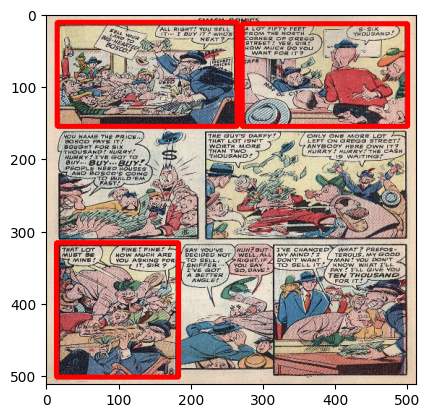

In [ ]:
# Visualize a sample image with bounding boxes

index = 0
output = train_dataset.__getitem__(index)
image = output[0].numpy().transpose((1, 2, 0))
boxes = output[1]['boxes'].numpy().astype(np.int32)

for box in boxes:
    cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 5)
plt.imshow(image)

## Panel Training

In [ ]:
# Load the pretrained model
model = fasterrcnn_resnet50_fpn()
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [ ]:
# Define the optimizer and the loss function
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [ ]:
def train(train_data_loader, model):
    print('Training')
    iteration = 0
    train_loss= []
    
     # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))
    
    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets, _ = data
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        train_loss.append(loss_value)
        losses.backward()
        optimizer.step()
        iteration += 1
    
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return np.mean(train_loss)

In [ ]:
def validate(valid_data_loader, model):
    print('Validating')
    iteration = 0
    valid_loss = []
    
    # initialize tqdm progress bar
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))
    
    for i, data in enumerate(prog_bar):
        images, targets, _ = data
        
        # Remove targets without any boxes
        new_targets = []
        new_images = []
        for i in range(len(targets)):
            t = targets[i]
            boxes = t['boxes']
            if len(boxes.shape) == 2 and boxes.shape[-1] == 4:
                new_targets.append(t)
                new_images.append(images[i])
        targets = new_targets
        images = new_images

        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        
        with torch.no_grad():
            loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        valid_loss.append(loss_value)
        iteration += 1
        
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return np.mean(valid_loss)

In [ ]:
NUM_EPOCHS = 15

import time
# from torchmetrics.detection.mean_ap import MeanAveragePrecision

train_losses = []
valid_losses = []

for epoch in range(NUM_EPOCHS):
    start_time = time.time()
    train_loss = train(train_data_loader, model)
    valid_loss = validate(valid_data_loader, model)
    end_time = time.time()
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    print('Epoch: {} \tTraining Loss: {:.4f} \tValidation Loss: {:.4f} \tTime: {:.4f}'.format(epoch+1, train_loss, valid_loss, end_time-start_time))

torch.save(model.state_dict(), f"/drive/MyDrive/panels_model{epoch+1}.pth")
model.eval()

Training


Loss: 0.4575: 100%|██████████| 55/55 [01:25<00:00,  1.56s/it]


Validating


Loss: 0.2991: 100%|██████████| 49/49 [00:49<00:00,  1.02s/it]


Epoch: 1 	Training Loss: 0.8246 	Validation Loss: 0.3530 	Time: 135.4366
Training


Loss: 0.3810: 100%|██████████| 55/55 [01:24<00:00,  1.53s/it]


Validating


Loss: 0.2720: 100%|██████████| 49/49 [00:49<00:00,  1.02s/it]


Epoch: 2 	Training Loss: 0.4710 	Validation Loss: 0.3339 	Time: 134.1725
Training


Loss: 0.3198: 100%|██████████| 55/55 [01:24<00:00,  1.54s/it]


Validating


Loss: 0.2335: 100%|██████████| 49/49 [00:49<00:00,  1.02s/it]


Epoch: 3 	Training Loss: 0.3600 	Validation Loss: 0.2745 	Time: 134.4565
Training


Loss: 0.3211: 100%|██████████| 55/55 [01:24<00:00,  1.54s/it]


Validating


Loss: 0.2229: 100%|██████████| 49/49 [00:49<00:00,  1.01s/it]


Epoch: 4 	Training Loss: 0.2901 	Validation Loss: 0.2644 	Time: 134.0752
Training


Loss: 0.2663: 100%|██████████| 55/55 [01:24<00:00,  1.53s/it]


Validating


Loss: 0.1771: 100%|██████████| 49/49 [00:49<00:00,  1.01s/it]


Epoch: 5 	Training Loss: 0.2592 	Validation Loss: 0.2269 	Time: 133.9546
Training


Loss: 0.2292: 100%|██████████| 55/55 [01:24<00:00,  1.53s/it]


Validating


Loss: 0.1959: 100%|██████████| 49/49 [00:49<00:00,  1.01s/it]


Epoch: 6 	Training Loss: 0.2343 	Validation Loss: 0.2284 	Time: 133.9171
Training


Loss: 0.2478: 100%|██████████| 55/55 [01:24<00:00,  1.54s/it]


Validating


Loss: 0.1975: 100%|██████████| 49/49 [00:49<00:00,  1.01s/it]


Epoch: 7 	Training Loss: 0.2224 	Validation Loss: 0.2208 	Time: 134.0222
Training


Loss: 0.1921: 100%|██████████| 55/55 [01:24<00:00,  1.54s/it]


Validating


Loss: 0.1942: 100%|██████████| 49/49 [00:49<00:00,  1.01s/it]


Epoch: 8 	Training Loss: 0.2090 	Validation Loss: 0.2255 	Time: 133.8944
Training


Loss: 0.2007: 100%|██████████| 55/55 [01:24<00:00,  1.53s/it]


Validating


Loss: 0.2005: 100%|██████████| 49/49 [00:48<00:00,  1.00it/s]


Epoch: 9 	Training Loss: 0.1885 	Validation Loss: 0.2161 	Time: 133.2547
Training


Loss: 0.1881: 100%|██████████| 55/55 [01:24<00:00,  1.54s/it]


Validating


Loss: 0.1985: 100%|██████████| 49/49 [00:48<00:00,  1.00it/s]


Epoch: 10 	Training Loss: 0.1821 	Validation Loss: 0.2133 	Time: 133.5430
Training


Loss: 0.1644: 100%|██████████| 55/55 [01:24<00:00,  1.54s/it]


Validating


Loss: 0.1947: 100%|██████████| 49/49 [00:48<00:00,  1.01it/s]


Epoch: 11 	Training Loss: 0.1681 	Validation Loss: 0.2072 	Time: 133.2770
Training


Loss: 0.1982: 100%|██████████| 55/55 [01:23<00:00,  1.53s/it]


Validating


Loss: 0.1833: 100%|██████████| 49/49 [00:49<00:00,  1.01s/it]


Epoch: 12 	Training Loss: 0.2189 	Validation Loss: 0.1940 	Time: 133.4799
Training


Loss: 0.1639: 100%|██████████| 55/55 [01:23<00:00,  1.52s/it]


Validating


Loss: 0.1580: 100%|██████████| 49/49 [00:49<00:00,  1.01s/it]


Epoch: 13 	Training Loss: 0.1660 	Validation Loss: 0.1950 	Time: 132.9484
Training


Loss: 0.1636: 100%|██████████| 55/55 [01:23<00:00,  1.52s/it]


Validating


Loss: 0.1698: 100%|██████████| 49/49 [00:49<00:00,  1.00s/it]


Epoch: 14 	Training Loss: 0.1646 	Validation Loss: 0.1960 	Time: 132.9539
Training


Loss: 0.1641: 100%|██████████| 55/55 [01:24<00:00,  1.53s/it]


Validating


Loss: 0.1617: 100%|██████████| 49/49 [00:49<00:00,  1.01s/it]


Epoch: 15 	Training Loss: 0.1553 	Validation Loss: 0.1841 	Time: 133.4634


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [ ]:
torch.save(model.state_dict(), f"model{epoch+1}.pth")
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

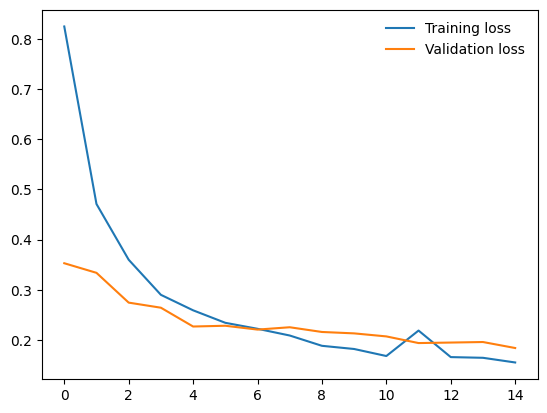

In [ ]:
# Plot the training and validation loss

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [ ]:
itr = tqdm(range(len(test_df)))

for i in itr:
    image_path = test_df.iloc[i]['image']
    image_name = image_path.split('/')[-1].split('.')[0]
    image = cv2.imread(image_path)
    orig_image = image.copy()
    # BGR to RGB
    image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB).astype(np.float32)
    # make the pixel range between 0 and 1
    image /= 255.0
    # bring color channels to front
    image = np.transpose(image, (2, 0, 1)).astype(np.float)
    # convert to tensor
    image = torch.tensor(image, dtype=torch.float).cuda()
    # add batch dimension
    image = torch.unsqueeze(image, 0)
    with torch.no_grad():
        pred = model(image)

    detection_threshold = 0.9


    # load all detection to CPU for further operations
    pred = [{k: v.to('cpu') for k, v in t.items()} for t in pred]

    if len(pred[0]['boxes']) != 0:
        boxes = pred[0]['boxes'].data.numpy()
        scores = pred[0]['scores'].data.numpy()
        # filter out boxes according to `detection_threshold`
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        draw_boxes = boxes.copy()

        
        # draw the bounding boxes and write the class name on top of it
        for j, box in enumerate(draw_boxes):
            cv2.rectangle(orig_image,
                        (int(box[0]), int(box[1])),
                        (int(box[2]), int(box[3])),
                        (0, 0, 255), 2)
            # cv2.putText(orig_image, pred_classes[j], 
            #             (int(box[0]), int(box[1]-5)),
            #             cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 
            #             2, lineType=cv2.LINE_AA)
        # cv2.imshow('Prediction', orig_image)
        # cv2.waitKey(1)
        cv2.imwrite(f"/drive/MyDrive/test_panels_predictions/{image_name}.jpg", orig_image,)
    # plt.figure(figsize=(10,10))
    # plt.imshow(img)

  0%|          | 0/895 [00:00<?, ?it/s]<ipython-input-72-0870afe5386f>:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  image = np.transpose(image, (2, 0, 1)).astype(np.float)
100%|██████████| 895/895 [04:01<00:00,  3.71it/s]


In [ ]:
pk.dump(test_df, open('/drive/MyDrive/test_panels_dataframe_tb.pk', 'wb'))

In [ ]:
pk.dump(train_df, open('/drive/MyDrive/train_panels_dataframe_tb.pk', 'wb'))

## Textbox Training

In [ ]:
import zipfile
with zipfile.ZipFile('textboxes_annotations.zip', 'r') as zip_ref:
    zip_ref.extractall('textboxes_annotations')

In [ ]:
textbox_path = 'textboxes_annotations/textboxes_annotations'
image_dir = os.path.join(textbox_path, 'Images')
annot_dir = os.path.join(textbox_path, 'Annotations')

In [ ]:
boxes = []
for annot_name in tqdm(os.listdir(annot_dir)):
    image_path = os.path.join(image_dir,annot_name.replace('.txt','.jpg'))
    annot_path = os.path.join(annot_dir,annot_name)

    image = np.array(Image.open(image_path))
    height, width = image.shape[:2]

    with open(annot_path) as file:
        for line in file:
            id, xmin, ymin, xmax, ymax = map(int, line.rstrip().split())
            boxes.append([image_path, xmin, xmax, ymin, ymax, id])
                

df = pd.DataFrame(boxes, columns=['image', 'xmin', 'xmax', 'ymin', 'ymax', 'id'])

100%|██████████| 1472/1472 [00:06<00:00, 222.18it/s]


In [ ]:
df.head()

,image,xmin,xmax,ymin,ymax,id
0,textboxes_annotations/textboxes_annotations/Im...,1,477,5,152,2
1,textboxes_annotations/textboxes_annotations/Im...,5,500,5,63,2
2,textboxes_annotations/textboxes_annotations/Im...,16,187,54,143,1
3,textboxes_annotations/textboxes_annotations/Im...,206,441,49,187,1
4,textboxes_annotations/textboxes_annotations/Im...,21,216,0,46,1


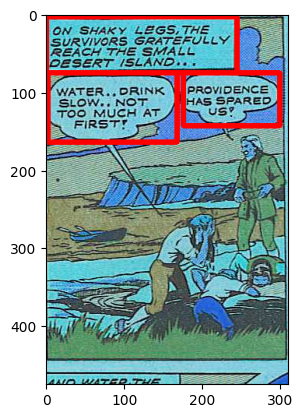

In [ ]:
# Plot a sample image with bounding boxes
sample = df.sample(1)
image_path = sample['image'].values[0]
image = cv2.imread(image_path)

for row in df[df['image'] == image_path].itertuples():
    cv2.rectangle(image, (row.xmin, row.ymin), (row.xmax, row.ymax), (255, 0, 0), 5)
    plt.imshow(image)

In [ ]:
# Split the dataset into train and test
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

In [ ]:
# Define the training tranforms
import albumentations as A

def get_train_transform():
    return A.Compose([
        A.MotionBlur(p=0.2),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.Blur(blur_limit=3, p=0.1),
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc',
        'label_fields': ['labels']
    })

# Define the validation transforms
def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc', 
        'label_fields': ['labels']
    })

In [ ]:
# Create the dataset class

class TextBoxDataset(Dataset):
    def __init__(self, df, width=512, height=512, transforms=None):
        self.df = df.reset_index()
        self.width = width
        self.height = height
        self.transforms = transforms
        self.images = df['image'].unique()

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image_path = self.df.loc[idx, 'image']
        image = cv2.imread(image_path)
        height, width = image.shape[:2]
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        image = cv2.resize(image, (self.width, self.height))

        image_panels = self.df[self.df['image'] == image_path]
        boxes = image_panels[['xmin', 'ymin', 'xmax', 'ymax']].values

        for i in range(len(boxes)):
            # Rescaling the bounding boxes
            xmin, ymin, xmax, ymax = boxes[i]
            xmin = xmin / width * self.width
            ymin = ymin / height * self.height
            xmax = xmax / width * self.width
            ymax = ymax / height * self.height
            boxes[i] = [xmin, ymin, xmax, ymax]

        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # Remove boxes with zero area
        boxes = boxes[area > 0]
        image_panels = image_panels[area > 0]
        area = area[area > 0]

        labels = torch.ones((image_panels.shape[0],), dtype=torch.int64)
        is_crowd = torch.zeros((image_panels.shape[0],), dtype=torch.int64)
        boxes = torch.as_tensor(boxes, dtype=torch.float64)
        if idx == 1:
            idx == 0
        image_id = torch.tensor([idx])
        area = torch.from_numpy(area)

        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': image_id,
            'area': area,
            'iscrowd': is_crowd
        }

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])

        return image, target, str(image_path.split('/')[-1])

        



In [ ]:
# Create the training and testing datasets
train_dataset = TextBoxDataset(train_df, transforms=get_train_transform())
test_dataset = TextBoxDataset(test_df, transforms=get_valid_transform())

def collate_fn(batch):
    return tuple(zip(*batch))

# Create the training and testing dataloaders
train_data_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

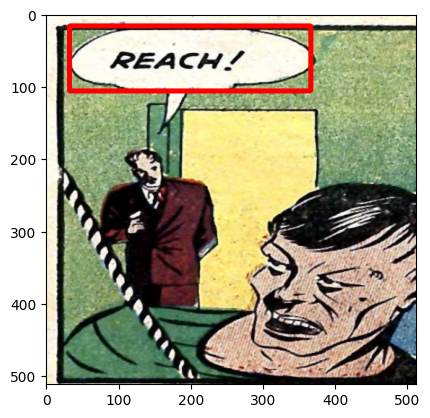

In [ ]:
# Visualize a sample image with bounding boxes

index = 0
output = train_dataset.__getitem__(index)
image = output[0].numpy().transpose((1, 2, 0))
boxes = output[1]['boxes'].numpy().astype(np.int32)

for box in boxes:
    cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 5)
plt.imshow(image)

In [ ]:
# Load the pretrained model
model = fasterrcnn_resnet50_fpn()
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [ ]:
# Define the optimizer and the loss function
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [ ]:
def train(train_data_loader, model):
    print('Training')
    iteration = 0
    train_loss= []
    
     # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))
    
    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets, _ = data
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        train_loss.append(loss_value)
        losses.backward()
        optimizer.step()
        iteration += 1
    
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return np.mean(train_loss)

In [ ]:
def validate(valid_data_loader, model):
    print('Validating')
    iteration = 0
    valid_loss = []
    
    # initialize tqdm progress bar
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))
    
    for i, data in enumerate(prog_bar):
        images, targets, _ = data
        
        # Remove targets without any boxes
        new_targets = []
        new_images = []
        for i in range(len(targets)):
            t = targets[i]
            boxes = t['boxes']
            if len(boxes.shape) == 2 and boxes.shape[-1] == 4:
                new_targets.append(t)
                new_images.append(images[i])
        targets = new_targets
        images = new_images

        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        
        with torch.no_grad():
            loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        valid_loss.append(loss_value)
        iteration += 1
        
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return np.mean(valid_loss)

In [ ]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


Training


Loss: 0.3534: 100%|██████████| 156/156 [03:56<00:00,  1.52s/it]


Validating


Loss: 0.2323: 100%|██████████| 85/85 [01:01<00:00,  1.38it/s]


Epoch: 1 	Training Loss: 0.4274 	Validation Loss: 0.2272 	Time: 298.4628
Training


Loss: 0.3551: 100%|██████████| 156/156 [03:53<00:00,  1.50s/it]


Validating


Loss: 0.1974: 100%|██████████| 85/85 [01:01<00:00,  1.38it/s]


Epoch: 2 	Training Loss: 0.3474 	Validation Loss: 0.2212 	Time: 295.7368
Training


Loss: 0.2859: 100%|██████████| 156/156 [03:54<00:00,  1.50s/it]


Validating


Loss: 0.1809: 100%|██████████| 85/85 [01:01<00:00,  1.37it/s]


Epoch: 3 	Training Loss: 0.3045 	Validation Loss: 0.2024 	Time: 296.0836
Training


Loss: 0.2295: 100%|██████████| 156/156 [03:54<00:00,  1.51s/it]


Validating


Loss: 0.1338: 100%|██████████| 85/85 [01:01<00:00,  1.38it/s]


Epoch: 4 	Training Loss: 0.2540 	Validation Loss: 0.1632 	Time: 296.7096
Training


Loss: 0.2161: 100%|██████████| 156/156 [03:55<00:00,  1.51s/it]


Validating


Loss: 0.1166: 100%|██████████| 85/85 [01:01<00:00,  1.38it/s]


Epoch: 5 	Training Loss: 0.2196 	Validation Loss: 0.1415 	Time: 297.2357
Training


Loss: 0.1764: 100%|██████████| 156/156 [03:55<00:00,  1.51s/it]


Validating


Loss: 0.1061: 100%|██████████| 85/85 [01:01<00:00,  1.38it/s]


Epoch: 6 	Training Loss: 0.1959 	Validation Loss: 0.1346 	Time: 297.2799
Training


Loss: 0.1478: 100%|██████████| 156/156 [03:55<00:00,  1.51s/it]


Validating


Loss: 0.1024: 100%|██████████| 85/85 [01:01<00:00,  1.38it/s]


Epoch: 7 	Training Loss: 0.1746 	Validation Loss: 0.1288 	Time: 297.3699
Training


Loss: 0.1305: 100%|██████████| 156/156 [03:55<00:00,  1.51s/it]


Validating


Loss: 0.0841: 100%|██████████| 85/85 [01:01<00:00,  1.38it/s]


Epoch: 8 	Training Loss: 0.1617 	Validation Loss: 0.1168 	Time: 296.8839
Training


Loss: 0.1414: 100%|██████████| 156/156 [03:55<00:00,  1.51s/it]


Validating


Loss: 0.0727: 100%|██████████| 85/85 [01:01<00:00,  1.38it/s]


Epoch: 9 	Training Loss: 0.1528 	Validation Loss: 0.1156 	Time: 297.5117
Training


Loss: 0.1163: 100%|██████████| 156/156 [03:55<00:00,  1.51s/it]


Validating


Loss: 0.0797: 100%|██████████| 85/85 [01:01<00:00,  1.38it/s]


Epoch: 10 	Training Loss: 0.1442 	Validation Loss: 0.1119 	Time: 297.0074
Training


Loss: 0.1450: 100%|██████████| 156/156 [03:55<00:00,  1.51s/it]


Validating


Loss: 0.0999: 100%|██████████| 85/85 [01:01<00:00,  1.38it/s]


Epoch: 11 	Training Loss: 0.1412 	Validation Loss: 0.1320 	Time: 296.7070
Training


Loss: 0.1201: 100%|██████████| 156/156 [03:54<00:00,  1.50s/it]


Validating


Loss: 0.0777: 100%|██████████| 85/85 [01:01<00:00,  1.38it/s]


Epoch: 12 	Training Loss: 0.1496 	Validation Loss: 0.1082 	Time: 296.1759
Training


Loss: 0.1237: 100%|██████████| 156/156 [03:55<00:00,  1.51s/it]


Validating


Loss: 0.0810: 100%|██████████| 85/85 [01:01<00:00,  1.38it/s]


Epoch: 13 	Training Loss: 0.1344 	Validation Loss: 0.1107 	Time: 296.9024
Training


Loss: 0.0800: 100%|██████████| 156/156 [03:55<00:00,  1.51s/it]


Validating


Loss: 0.0665: 100%|██████████| 85/85 [01:01<00:00,  1.39it/s]


Epoch: 14 	Training Loss: 0.1285 	Validation Loss: 0.1000 	Time: 296.7707
Training


Loss: 0.1075: 100%|██████████| 156/156 [03:55<00:00,  1.51s/it]


Validating


Loss: 0.0705: 100%|██████████| 85/85 [01:01<00:00,  1.39it/s]


Epoch: 15 	Training Loss: 0.1256 	Validation Loss: 0.1013 	Time: 296.3343


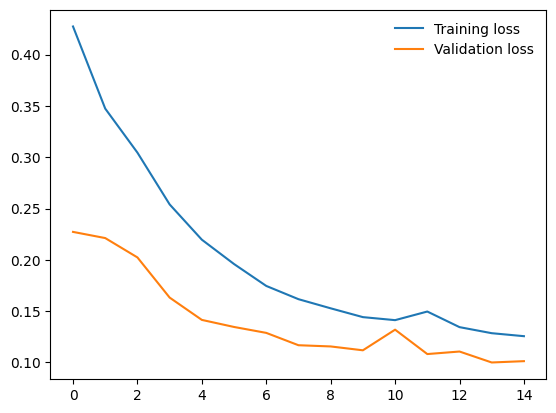

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [ ]:
NUM_EPOCHS = 15

import time
# from torchmetrics.detection.mean_ap import MeanAveragePrecision

train_losses = []
valid_losses = []

for epoch in range(NUM_EPOCHS):
    start_time = time.time()
    train_loss = train(train_data_loader, model)
    valid_loss = validate(valid_data_loader, model)
    end_time = time.time()
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    print('Epoch: {} \tTraining Loss: {:.4f} \tValidation Loss: {:.4f} \tTime: {:.4f}'.format(epoch+1, train_loss, valid_loss, end_time-start_time))

torch.save(model.state_dict(), f"/drive/MyDrive/textbox_model{epoch+1}.pth")

# Plot the training and validation loss

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

model.eval()

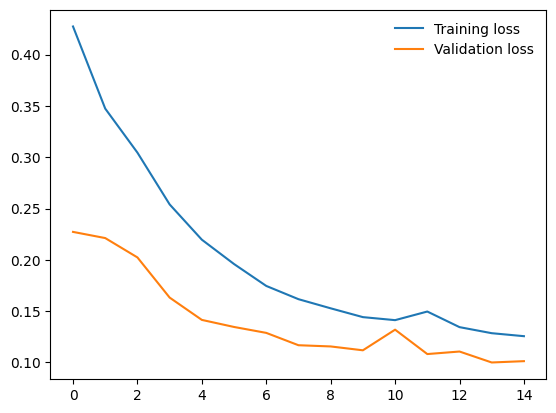

In [ ]:
# Plot the training and validation loss

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [ ]:
itr = tqdm(range(len(test_df)))
predictions = []

for i in itr:
    image_path = test_df.iloc[i]['image']
    image_name = image_path.split('/')[-1].split('.')[0]
    image = cv2.imread(image_path)
    orig_image = image.copy()
    # BGR to RGB
    image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB).astype(np.float32)
    # make the pixel range between 0 and 1
    image /= 255.0
    # bring color channels to front
    image = np.transpose(image, (2, 0, 1)).astype(np.float)
    # convert to tensor
    image = torch.tensor(image, dtype=torch.float).cuda()
    # add batch dimension
    image = torch.unsqueeze(image, 0)
    with torch.no_grad():
        pred = model(image)

    detection_threshold = 0.9


    # load all detection to CPU for further operations
    pred = [{k: v.to('cpu') for k, v in t.items()} for t in pred]

    if len(pred[0]['boxes']) != 0:
        boxes = pred[0]['boxes'].data.numpy()
        scores = pred[0]['scores'].data.numpy()
        # filter out boxes according to `detection_threshold`
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        draw_boxes = boxes.copy()

        predictions.append((image_name, boxes))

        
        # draw the bounding boxes and write the class name on top of it
        for j, box in enumerate(draw_boxes):
            cv2.rectangle(orig_image,
                        (int(box[0]), int(box[1])),
                        (int(box[2]), int(box[3])),
                        (0, 0, 255), 2)
            # cv2.putText(orig_image, pred_classes[j], 
            #             (int(box[0]), int(box[1]-5)),
            #             cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 
            #             2, lineType=cv2.LINE_AA)
        # cv2.imshow('Prediction', orig_image)
        # cv2.waitKey(1)
        cv2.imwrite(f"/drive/MyDrive/CV Data/FasterRCNN/textboxes/test_predictions/{image_name}.jpg", orig_image,)
    # plt.figure(figsize=(10,10))
    # plt.imshow(img)

  0%|          | 0/808 [00:00<?, ?it/s]<ipython-input-14-c1535eb83c4a>:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  image = np.transpose(image, (2, 0, 1)).astype(np.float)
100%|██████████| 808/808 [06:48<00:00,  1.98it/s]


In [ ]:
test_df.iloc[0]

image    panels_annotations/panels_annotations/Images/1...
xmin                                                   605
xmax                                                   912
ymin                                                    15
ymax                                                   464
id                                                       0
Name: 2408, dtype: object

IOU scores for Panel Detection

In [ ]:
pk.dump(pred, open('/drive/MyDrive/pn_predictions.pk', 'wb'))

In [ ]:
test_df = pk.load(open('/drive/MyDrive/CV Data/FasterRCNN/Panels/test_panels_dataframe_tb.pk', 'rb'))
test_df.head()

,image,xmin,xmax,ymin,ymax,id
2408,panels_annotations/panels_annotations/Images/1...,605,912,15,464,0
1472,panels_annotations/panels_annotations/Images/2...,32,433,1238,1821,0
881,panels_annotations/panels_annotations/Images/8...,32,603,1082,1603,0
331,panels_annotations/panels_annotations/Images/2...,84,1012,1518,2167,0
1835,panels_annotations/panels_annotations/Images/9...,32,621,1126,1641,0


In [ ]:
predictions = pk.load(open('/drive/MyDrive/CV Data/FasterRCNN/Panels/pn_predictions.pk', 'rb'))

In [ ]:
len(predictions)

1

In [ ]:
checkpoint = torch.load('/drive/MyDrive/CV Data/FasterRCNN/Panels/panels_model15.pth')


In [ ]:
model = fasterrcnn_resnet50_fpn()
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.load_state_dict(checkpoint)
model.to('cuda')
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [ ]:
checkpoint.keys()

odict_keys(['backbone.body.conv1.weight', 'backbone.body.bn1.weight', 'backbone.body.bn1.bias', 'backbone.body.bn1.running_mean', 'backbone.body.bn1.running_var', 'backbone.body.layer1.0.conv1.weight', 'backbone.body.layer1.0.bn1.weight', 'backbone.body.layer1.0.bn1.bias', 'backbone.body.layer1.0.bn1.running_mean', 'backbone.body.layer1.0.bn1.running_var', 'backbone.body.layer1.0.conv2.weight', 'backbone.body.layer1.0.bn2.weight', 'backbone.body.layer1.0.bn2.bias', 'backbone.body.layer1.0.bn2.running_mean', 'backbone.body.layer1.0.bn2.running_var', 'backbone.body.layer1.0.conv3.weight', 'backbone.body.layer1.0.bn3.weight', 'backbone.body.layer1.0.bn3.bias', 'backbone.body.layer1.0.bn3.running_mean', 'backbone.body.layer1.0.bn3.running_var', 'backbone.body.layer1.0.downsample.0.weight', 'backbone.body.layer1.0.downsample.1.weight', 'backbone.body.layer1.0.downsample.1.bias', 'backbone.body.layer1.0.downsample.1.running_mean', 'backbone.body.layer1.0.downsample.1.running_var', 'backbone.

In [ ]:
predictions

[('1298_9',
  array([[  11,  457,  440,  918],
         [   7,  911,  474, 1362],
         [ 466,  900,  919, 1378],
         [ 330,    7,  601,  460],
         [   6,   13,  330,  462],
         [ 608,    9,  916,  463],
         [ 467,  459,  923,  915]], dtype=int32)),
 ('238_19',
  array([[ 632,  631, 1273, 1241],
         [ 429,    0,  850,  642],
         [ 435, 1234,  848, 1819],
         [ 856, 1227, 1253, 1831],
         [  29,   59,  427,  642],
         [ 836,   51, 1258,  642],
         [  23, 1226,  432, 1833],
         [  27,  615,  632, 1247]], dtype=int32)),
 ('824_14',
  array([[  31, 1084,  628, 1608],
         [  25,   41,  595,  572],
         [  25,  554,  586, 1076],
         [ 591,   38, 1164,  551],
         [ 598, 1059, 1176, 1626],
         [ 585,  536, 1165, 1078]], dtype=int32)),
 ('201_14',
  array([[1013,  795, 1978, 1497],
         [1021, 1520, 1986, 2174],
         [ 988,  114, 1986,  798],
         [  73, 1516, 1010, 2176],
         [  75,  118,  983, 1

In [ ]:
pk.dump(predictions, open('/drive/MyDrive/CV Data/FasterRCNN/Panels/panel_predictions.pk', 'wb'))

In [ ]:
df['image_name'] = df.apply(lambda x: x['image'].split('/')[-1].split('.')[0], axis=1)
df.reset_index()
df.head()

,image,xmin,xmax,ymin,ymax,id,image_name
0,panels_annotations/panels_annotations/Images/1...,38,627,34,613,0,1674_20
1,panels_annotations/panels_annotations/Images/1...,644,1245,34,615,0,1674_20
2,panels_annotations/panels_annotations/Images/1...,30,635,626,1209,0,1674_20
3,panels_annotations/panels_annotations/Images/1...,644,1249,626,1213,0,1674_20
4,panels_annotations/panels_annotations/Images/1...,30,675,1222,1801,0,1674_20


In [ ]:
pred = predictions[0]
pred

('1298_9',
 array([[  11,  457,  440,  918],
        [   7,  911,  474, 1362],
        [ 466,  900,  919, 1378],
        [ 330,    7,  601,  460],
        [   6,   13,  330,  462],
        [ 608,    9,  916,  463],
        [ 467,  459,  923,  915]], dtype=int32))

In [ ]:
boxes_gt = df[df['image_name'] == pred[0]][['xmin', 'ymin', 'xmax', 'ymax']].to_numpy()
boxes_gt

array([[  18,   20,  326,  459],
       [ 331,   17,  594,  462],
       [ 605,   15,  912,  464],
       [  19,  470,  461,  906],
       [ 472,  463,  915,  910],
       [  22,  915,  460, 1356],
       [ 472,  919,  914, 1360]])

In [ ]:
def intersection_over_union(gt_box, pred_box):
    inter_box_top_left = [max(gt_box[0], pred_box[0]), max(gt_box[1], pred_box[1])]
    inter_box_bottom_right = [min(gt_box[0]+gt_box[2], pred_box[0]+pred_box[2]), min(gt_box[1]+gt_box[3], pred_box[1]+pred_box[3])]

    inter_box_w = inter_box_bottom_right[0] - inter_box_top_left[0]
    inter_box_h = inter_box_bottom_right[1] - inter_box_top_left[1]

    intersection = inter_box_w * inter_box_h
    union = gt_box[2] * gt_box[3] + pred_box[2] * pred_box[3] - intersection
    
    iou = intersection / union

    return iou, intersection, union,

In [ ]:
mean_ious = []
image_visited = set()

for pred in predictions:
  if pred[0] in image_visited:
    continue
  
  image_visited.add(pred[0])

  boxes_gt = df[df['image_name'] == pred[0]][['xmin', 'ymin', 'xmax', 'ymax']].to_numpy()
  ious = []
  for box in pred[1]:
    max_iou = 0
    max_index = 0
    for idx, box_gt in enumerate(boxes_gt):
      iou, intersection, union = intersection_over_union(box_gt, box)
      if abs(iou) > max_iou:
        max_iou = abs(iou)
        max_index = idx
    np.delete(boxes_gt, max_index)
    ious.append(max_iou)
  mean_ious.append(np.mean(ious))
  
mean_ious

[0.951084185416991,
 0.9432112604847065,
 0.9603858214936466,
 0.966828971447382,
 0.9616149057394571,
 0.9479065433147292,
 0.9033946019811484,
 0.886263851850125,
 0.7147506923039239,
 0.9353342232594131,
 0.9479244804697907,
 0.9310502911277723,
 0.9353761873834893,
 0.842693462530702,
 0.9778456821229817,
 0.962840211724529,
 0.9160743249635889,
 0.9563292563839241,
 0.8883257489404865,
 0.9557012287230461,
 0.9460063450391974,
 0.9617455913943601,
 0.9284345628358709,
 0.962070557520702,
 0.8481648362532344,
 0.9590243871193033,
 0.8376459786472937,
 0.9523418497672836,
 0.9683867204879006,
 0.9475683272465493,
 0.7024864367036066,
 0.9645065210106529,
 0.9420056409175948,
 0.7334834223839568,
 0.9370225648402256,
 0.7305435823241642,
 0.9381285351942916,
 0.9102947827581561,
 0.9487377490677655,
 0.9146281859257819,
 0.9531381275089746,
 0.9408196743836598,
 0.9381490244343244,
 0.9360771118598443,
 0.9477418647873712,
 0.730742412869107,
 0.8565854089047837,
 0.9531504371218948,

In [ ]:
np.mean(mean_ious)

0.9145654961558457

In [ ]:
len(image_visited)

386

IOU scores for textbox annotations

In [ ]:
test_df = pk.load(open('/drive/MyDrive/CV Data/FasterRCNN/textboxes/test_dataframe_tb.pk', 'rb'))
test_df.head()

,image,xmin,xmax,ymin,ymax,id
2281,textboxes_annotations/textboxes_annotations/Im...,497,670,18,142,1
2220,textboxes_annotations/textboxes_annotations/Im...,424,555,27,118,1
368,textboxes_annotations/textboxes_annotations/Im...,16,373,62,198,1
535,textboxes_annotations/textboxes_annotations/Im...,0,99,100,148,1
2425,textboxes_annotations/textboxes_annotations/Im...,1,182,25,191,1


In [ ]:
checkpoint = torch.load('/drive/MyDrive/CV Data/FasterRCNN/textboxes/textbox_model15.pth')


In [ ]:
model = fasterrcnn_resnet50_fpn()
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.load_state_dict(checkpoint)
model.to('cuda')
model.eval()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 175MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [ ]:
pk.dump(predictions, open('/drive/MyDrive/CV Data/FasterRCNN/textboxes/textbox_predictions.pk', 'wb'))

In [ ]:
df['image_name'] = df.apply(lambda x: x['image'].split('/')[-1].split('.')[0], axis=1)
df.reset_index()
df.head()

,image,xmin,xmax,ymin,ymax,id,image_name
0,textboxes_annotations/textboxes_annotations/Im...,1,477,5,152,2,3351_27_0
1,textboxes_annotations/textboxes_annotations/Im...,5,500,5,63,2,2690_15_3
2,textboxes_annotations/textboxes_annotations/Im...,16,187,54,143,1,2690_15_3
3,textboxes_annotations/textboxes_annotations/Im...,206,441,49,187,1,2690_15_3
4,textboxes_annotations/textboxes_annotations/Im...,21,216,0,46,1,2739_62_1


In [ ]:
mean_ious = []
image_visited = set()

for pred in predictions:
  if pred[0] in image_visited:
    continue
  
  image_visited.add(pred[0])

  boxes_gt = df[df['image_name'] == pred[0]][['xmin', 'ymin', 'xmax', 'ymax']].to_numpy()
  ious = []
  if len(pred[1]) > 0:
    for box in pred[1]:
      max_iou = 0
      max_index = 0
      for idx, box_gt in enumerate(boxes_gt):
        iou, intersection, union = intersection_over_union(box_gt, box)
        if abs(iou) > max_iou:
          max_iou = abs(iou)
          max_index = idx
      np.delete(boxes_gt, max_index)
      ious.append(max_iou)
    mean_ious.append(np.mean(ious))
  
mean_ious

[0.9272588152212199,
 0.9365747325652737,
 0.8435448412849493,
 0.6737198663937067,
 0.7843339225125646,
 0.92147061495372,
 0.8534425374764507,
 0.8889230363963647,
 0.9771904757588483,
 0.906932739529599,
 0.9432225657473686,
 0.8775627468189933,
 0.9151999871029529,
 0.9148893201235893,
 0.8784791077242653,
 0.886815007932293,
 0.9007056029207557,
 0.9388132879727836,
 0.9287986095606563,
 0.8543765281173594,
 0.8691916131101782,
 0.9012424436082377,
 0.8325133304139513,
 0.9187808389549149,
 0.8381984987489575,
 0.8930608023006072,
 0.9258782907224654,
 0.9410035837948124,
 0.8717230240404433,
 0.9254821893601693,
 0.6005230193552343,
 0.9178952889960641,
 0.8792882822497106,
 0.8989578613502492,
 0.90834177406014,
 0.9312927918582177,
 0.980217708497927,
 0.9137683869071068,
 0.8988821709698444,
 0.9249636512313835,
 0.7945937289978282,
 0.895035970566014,
 0.8252937271184667,
 0.9154966672504172,
 0.9535160905840286,
 0.8639507734585015,
 0.7628760836308006,
 0.9106675359202636,


In [ ]:
np.mean(mean_ious)

0.8796859310017998

In [ ]:
len(image_visited)

678